In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
# Nicer plotting
import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8,4)

# Simple Impact-T Run

In [3]:
from impact import Impact, template_dir

import matplotlib.pyplot as plt
import os

In [4]:
ifile = os.path.join(template_dir,'lcls_injector/ImpactT.in')
os.path.exists(ifile)

True

In [5]:
# Make Impact object
I = Impact(ifile, verbose=True)

Configured to run in: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpgdt6zgt7


In [6]:
# Change some things
I.header['Np'] = 10000
I.header['Nx'] = 16
I.header['Ny'] = 16
I.header['Nz'] = 16
I.header['Dt'] = 5e-13

# Turn Space Charge off. Both these syntax work
I.header['Bcurr'] = 0 
I['header:Bcurr'] = 0 

# Other switches
I.timeout = 1000

# Switches for MPI
I.use_mpi=True
I.header['Nprow'] = 1
I.header['Npcol'] = 4
I.impact_bin = '$IMPACTT_MPI_BIN'
assert os.path.exists(os.path.expandvars(I.impact_bin))

# Show repr
I

<Impact with 10000 particles, stopping at 0.1 m, at 0x7f7fd31a3910>

In [7]:
# Change stop location
I.stop = 3.0
# This is does the same: I.ele['stop_1']['s'] = 1

Removed element: stop_1
Set stop to s = 3.0


In [8]:
I.run()

Running Impact-T in /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmpgdt6zgt7
Loaded fort 30 : Fourth root of the fourth moments of the beam distribution
Loaded fort 25 : RMS Y information
Loaded fort 24 : RMS X information
Loaded fort 26 : RMS Z information
Loaded fort 28 : Load balance and loss diagnostics
Loaded fort 29 : Cube root of third moments of the beam distribution
Loaded fort 18 : Time and energy
Loaded fort 27 : Max amplitude information
Loaded fort 70 : Slice information of the final distribution
Loaded fort 60 : Slice information of the initial distribution
Loading particles
Loaded fort 40 : initial particle distribution at t = 0
Loaded fort 50 : final particle distribution projected to the centroid location of the bunch
Loaded write beam particles YAG02 fort.41
Converting z to t according to cathode_kinetic_energy_ref = 1.0 eV
Converted initial_particles to ParticleGroup
Converted final_particles to ParticleGroup
Converted YAG02 to ParticleGroup


In [9]:
# These are used to create the input
I.input.keys()

dict_keys(['original_input', 'input_particle_file', 'header', 'lattice', 'fieldmaps'])

In [10]:
# This is the output parsed
I.output.keys()

dict_keys(['run_info', 'stats', 'slice_info', 'particles'])

In [11]:
# stats from the various fort. files
I.output['stats'].keys()

dict_keys(['t', 'mean_z', 'moment4_x', 'moment4_y', 'moment4_z', 'mean_y', 'sigma_y', 'norm_emit_y', 'mean_x', 'sigma_x', 'norm_emit_x', 'sigma_z', 'norm_emit_z', 'loadbalance_min_n_particle', 'loadbalance_max_n_particle', 'n_particle', 'moment3_x', 'moment3_y', 'moment3_z', 'mean_gamma', 'mean_beta', 'max_r', 'sigma_gamma', 'max_amplitude_x', 'max_amplitude_y', 'max_amplitude_z', 'moment4_px', 'moment4_py', 'moment4_pz', 'mean_py', 'sigma_py', 'cov_y__py', 'mean_px', 'sigma_px', 'cov_x__px', 'mean_pz', 'sigma_pz', 'cov_z__pz', 'moment3_px', 'moment3_py', 'moment3_pz', 'mean_kinetic_energy', 'max_amplitude_px', 'max_amplitude_py', 'max_amplitude_pz'])

In [12]:
# Slice info
I.output['slice_info'].keys()

dict_keys(['final_particle_slices', 'initial_particle_slices'])

# Particles

In [13]:
# Particles are automatically parsed in to openpmd-beamphysics ParticleGroup objects
I.output['particles']

{'initial_particles': <ParticleGroup with 10000 particles at 0x7f7fd2fa3cd0>,
 'final_particles': <ParticleGroup with 10000 particles at 0x7f7fd3478450>,
 'YAG02': <ParticleGroup with 10000 particles at 0x7f7fd3478650>}

In [14]:
# Get the final particles, calculate some statistic
P = I.output['particles']['YAG02']
P['mean_energy']

5932350.098767299

In [15]:
# Show the units
P.units('mean_energy')

pmd_unit('eV', 1.602176634e-19, (2, 1, -2, 0, 0, 0, 0))

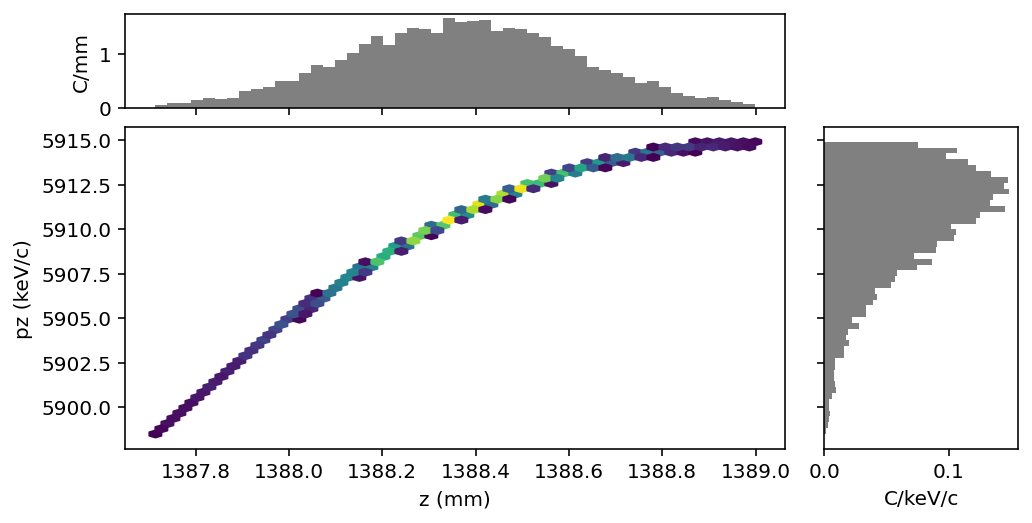

In [16]:
# ParticleGroup has built-in plotting
P.plot('z', 'pz')

# Stats

In [17]:
# Impact's own calculated statistics can be retieved
len(I.stat('norm_emit_x')), I.stat('norm_emit_x')[-1]

(4095, 2.5241286e-07)

In [18]:
# Stats can also be computed from the particles. For example:
I.particles['final_particles']['norm_emit_x']

2.5192583687443604e-07

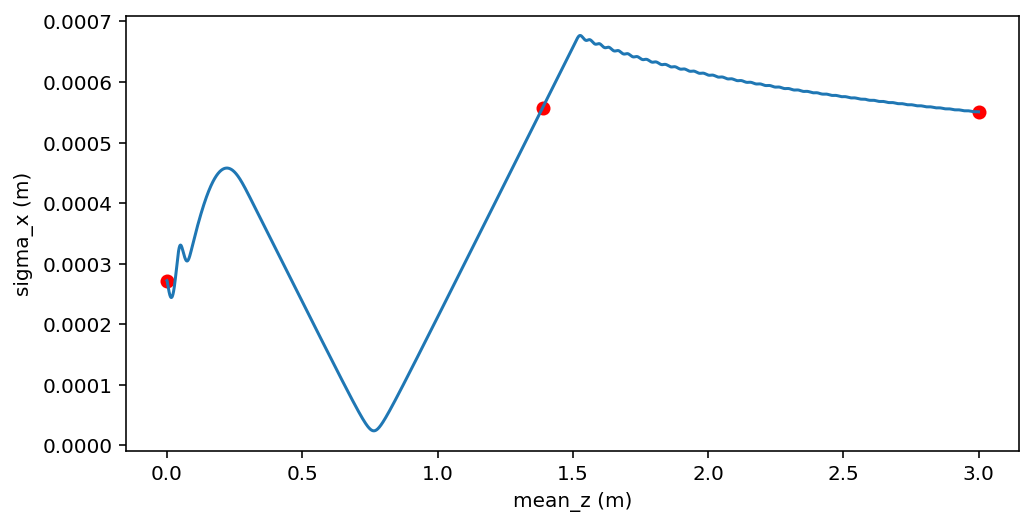

In [19]:
# Compare these. 
key1 = 'mean_z'
key2 = 'sigma_x'
units1 = str(I.units(key1))
units2 = str(I.units(key2))
plt.xlabel(key1+f' ({units1})')
plt.ylabel(key2+f' ({units2})')
plt.plot(I.stat(key1), I.stat(key2))
plt.scatter(
    [I.particles[name][key1] for name in I.particles], 
    [I.particles[name][key2] for name in I.particles], color='red')

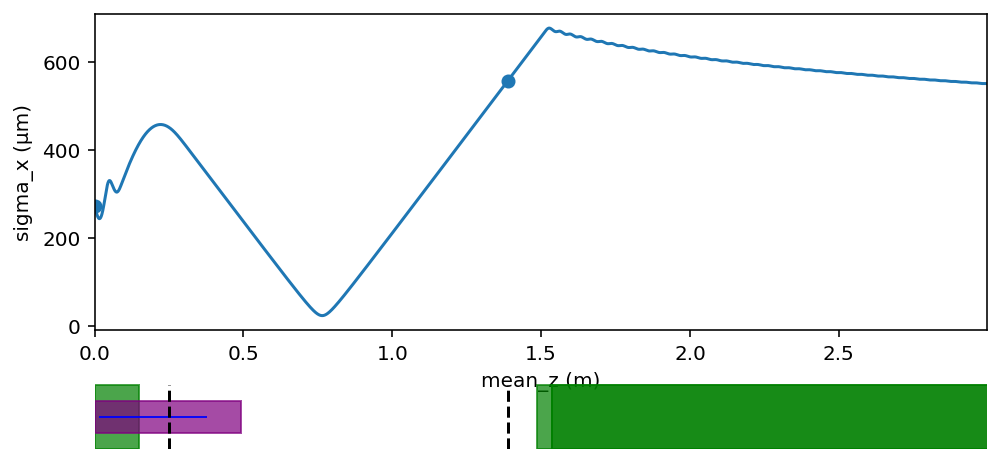

In [20]:
# This kind of plot is built-in for convenience, with a layout
I.plot('sigma_x')

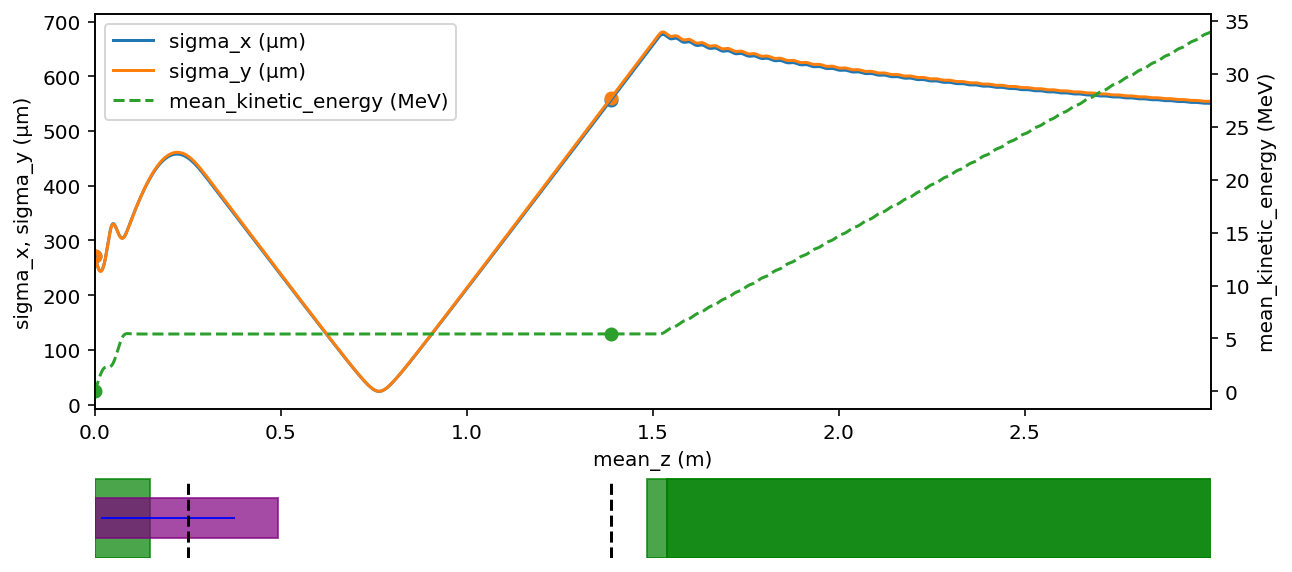

In [21]:
# Even fancier options, and sending some options to matplotlib
I.plot(['sigma_x', 'sigma_y'], y2=['mean_kinetic_energy'], figsize=(10,5))

# Partial tracking

Particles can be started anywhere in the lattice. Here we will take some intermediate particles, and re-track. 

In [22]:
# Get particles 
Pmid = I.particles['YAG02']

# Make a copy, so that the previous object is preserved. 
I2 = I.copy()
I.verbose=False
# The copy needs to be configured before tracking
I2.configure()

# Track to 2 m
Pfinal = I2.track(Pmid, 2.0)

Configured to run in: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp3e3ol8hx
Removed element: stop_1
Set stop to s = 2.0
Running Impact-T in /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp3e3ol8hx
Some initial particles z !=0, disabling cathode_start
writing 10000 particles to /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp3e3ol8hx/partcl.data
Normal start with at time 4.6699999335882385e-09 s
Normal start: Replaced Np with 10000 according to initial particles
Normal start: Replaced Tini with 4.6699999335882385e-09 according to initial particles
Normal start: Replaced Flagimg with 0 according to initial particles
Loaded fort 30 : Fourth root of the fourth moments of the beam distribution
Loaded fort 25 : RMS Y information
Loaded fort 24 : RMS X information
Loaded fort 26 : RMS Z information
Loaded fort 28 : Load balance and loss diagnostics
Loaded fort 29 : Cube root of third moments of the beam distribution
Loaded fort 18 : Time and energy
Loaded fort 27 : Max amplitud

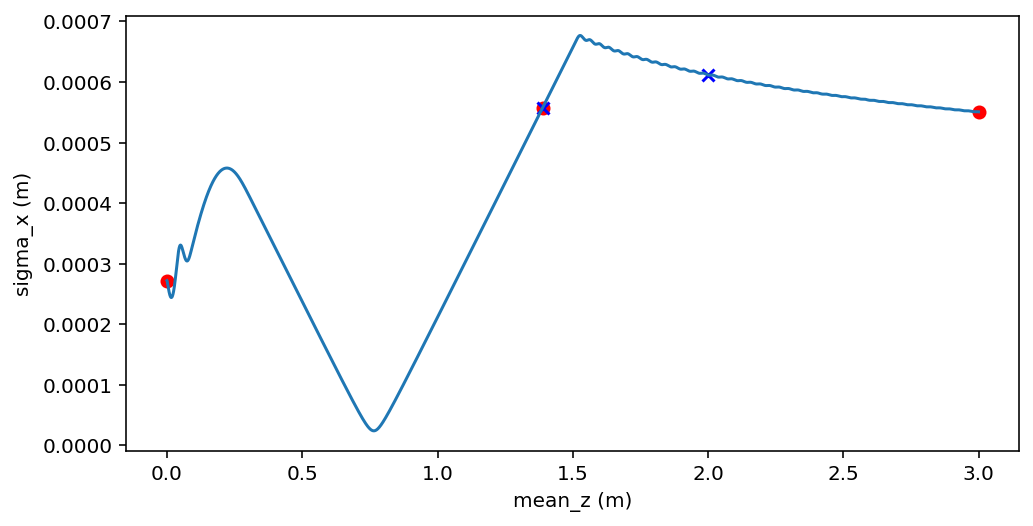

In [23]:
# Compare these. 
key1 = 'mean_z'
key2 = 'sigma_x'
units1 = str(I.units(key1))
units2 = str(I.units(key2))
plt.xlabel(key1+f' ({units1})')
plt.ylabel(key2+f' ({units2})')
plt.plot(I.stat(key1), I.stat(key2))
plt.scatter(
    [I.particles[name][key1] for name in I.particles], 
    [I.particles[name][key2] for name in I.particles], color='red')

# Blue X are retracked particles
plt.scatter(
    [P[key1] for P in [Pmid, Pfinal]], 
    [P[key2] for P in [Pmid, Pfinal]], color='blue', marker='x')

# Single particle tracking

Similar to above, but with initial conditions specified in the function for a single particle. 

This is useful for auto-phasing and scaling elements, and tracing reference orbits. 

Space charge is turned off for single particle tracking.

In [24]:
%%time
I3 = I.copy()
I3.verbose=False
I3.configure()
P3 = I3.track1(s=2.2, z0 = 1.0, pz0=10e6)
P3.z, P3.gamma

CPU times: user 201 ms, sys: 51.7 ms, total: 253 ms
Wall time: 668 ms


(array([2.19999866]), array([4.44092247]))

# Interactive Layout

In [25]:
from bokeh.plotting import output_notebook
from bokeh.plotting import show
output_notebook(hide_banner=True)

from impact.plotting import layout_plot

In [26]:
# Change somethone
I.ele['QE01']['b1_gradient'] = 0
layout = layout_plot(I.input['lattice'], plot_height=300)
show(layout)

# ControlGroup objects

Some elements need to be changed together, either relatively or absolutely. A single traveling wave cavity, for example, is made from four fieldmaps, with defined relative phases


In [27]:
for name in ['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit']:
     print(name, I[name]['theta0_deg'])

L0A_entrance 258.5
L0A_body_1 288.5
L0A_body_2 348.5
L0A_exit 258.5


In [28]:
I4 = I.copy()

# Add a group to control these. 
I4.add_group('L0A', ele_names=['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit'], var_name='theta0_deg', attributes='theta0_deg')

ControlGroup(**{"ele_names": ["L0A_entrance", "L0A_body_1", "L0A_body_2", "L0A_exit"], "var_name": "theta0_deg", "attributes": ["theta0_deg", "theta0_deg", "theta0_deg", "theta0_deg"], "factors": [1.0, 1.0, 1.0, 1.0], "absolute": false, "value": 0})

In [29]:
# Make a change
I4['L0A']['theta0_deg'] = 0.123456

# These get propagated to the underlying elements
for name in I4['L0A'].ele_names:
     print(name, I4[name]['theta0_deg'])

L0A_entrance 258.623456
L0A_body_1 288.623456
L0A_body_2 348.623456
L0A_exit 258.623456


In [30]:
# Overall scaling, respecting the special factors. 
I4.add_group('L0A_scale', ele_names=['L0A_entrance', 'L0A_body_1', 'L0A_body_2', 'L0A_exit'],
                   var_name = 'rf_field_scale',
                  factors = [0.86571945106805, 1, 1, 0.86571945106805],  # sin(k*d) with d = 3.5e-2 m 
                  absolute=True)

I4['L0A_scale']['rf_field_scale'] = 10

In [31]:
# These get propagated to the underlying elements
for name in I4['L0A_scale'].ele_names:
     print(name, I4[name]['rf_field_scale'])

L0A_entrance 8.657194510680501
L0A_body_1 10
L0A_body_2 10
L0A_exit 8.657194510680501


# Instantiate from YAML

All of the Impact object init arguments can be passed in a YAML file. Any of:

In [32]:
?Impact

Init signature:
Impact(
    input_file=None,
    initial_particles=None,
    impact_bin='$IMPACTT_BIN',
    use_tempdir=True,
    workdir=None,
    use_mpi=False,
    mpi_exe='mpirun',
    group=None,
    verbose=False,
)
Docstring:     
Files will be written into a temporary directory within workdir. 
If workdir=None, a location will be determined by the system. 
File:           ~/Code/GitHub/lume-impact/impact/impact.py
Type:           type
Subclasses:     


In [33]:
YAML="""

# Any argument above. One exception is initial_particles: this should be a filename that is parsed into a ParticleGroup

input_file: ../templates/lcls_injector/ImpactT.in

verbose: True

group:
  L0A:
    ele_names: [ L0A_entrance, L0A_body_1, L0A_body_2, L0A_exit ]
    var_name: theta0_deg
    attributes: theta0_deg
    value: 0
    
  L0B:
    ele_names: [ L0B_entrance, L0B_body_1, L0B_body_2, L0B_exit ]
    var_name: theta0_deg
    attributes: theta0_deg
    value: 0    
    
  L0A_scale:
    ele_names:  [ L0A_entrance, L0A_body_1, L0A_body_2, L0A_exit ]
    var_name: rf_field_scale'
    factors: [0.86571945106805, 1, 1, 0.86571945106805]  # sin(k*d) with d = 3.5e-2 m 
    absolute: True    
    
  L0B_scale:
    ele_names:  [ L0B_entrance, L0B_body_1, L0B_body_2, L0B_exit ]
    var_name: rf_field_scale'
    factors: [0.86571945106805, 1, 1, 0.86571945106805]  # sin(k*d) with d = 3.5e-2 m 
    absolute: True
    

"""
I5 = Impact.from_yaml(YAML)
I5['L0A:theta0_deg'], I5['L0A_entrance:theta0_deg']

Configured to run in: /var/folders/wj/lfgr01993dx79p9cm_skykbw0000gn/T/tmp8qlht7yq


(0, 258.5)

# Archive all output

All of .input and .output can be archived and loaded from standard h5 files.

Particles are stored in the openPMD-beamphysics format.

In [34]:
# Call the archive function. If no name is given, a name will be invented based on the fingerprint.
afile = I.archive()

In [35]:
# This can be loaded into an empty model
I2 = Impact()
I2.load_archive(afile)

In [36]:
# This also works
I2 = Impact.from_archive(afile)

In [37]:
# Check that the fingerprints are the same
I.fingerprint() == I2.fingerprint()

True

In [38]:
# Look at a stat, and compare with the original object
I.stat('norm_emit_x')[-1], I2.stat('norm_emit_x')[-1]

(2.5241286e-07, 2.5241286e-07)

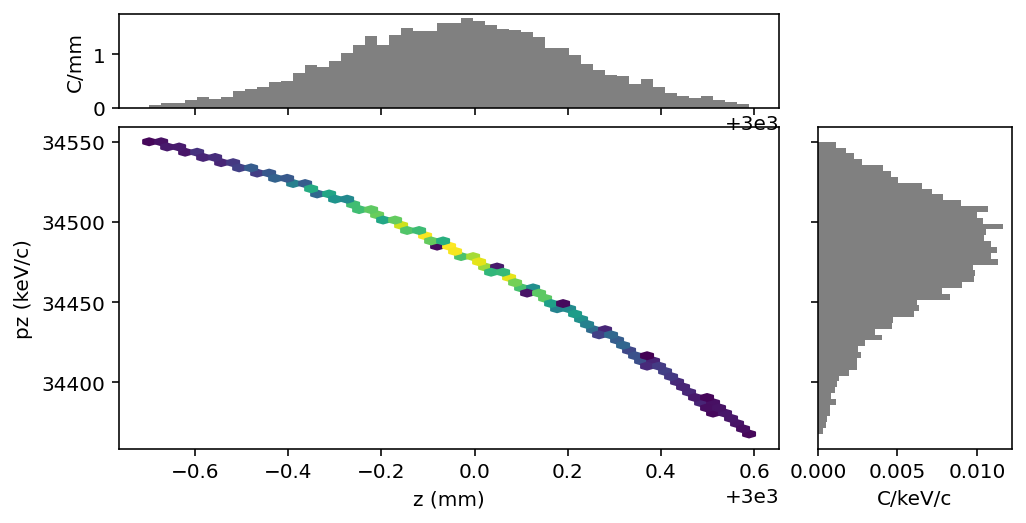

In [39]:
# The particles look the same
I2.particles['final_particles'].plot('z', 'pz')

In [40]:
# Cleanup
os.remove(afile)